<a href="https://colab.research.google.com/github/lf2foce/quant/blob/master/iterrows_test_multiple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install 'PyPortfolioOpt==1.2.3'

Vốn đầu tư ban đầu 1000cp * 4 mã: 288264911.16499853
Expected annualized return: 0.36461
Standard deviation (Volatility): 0.2654
portfolio sharpe 1.3738
vs  
Expected annualized return ew: 0.5954
Standard deviation (Volatility) ew: 0.29178
portfolio sharpe ew 2.0406
2018-03-30 00:00:00
------------
OrderedDict([('FPT', 0.0), ('HPG', 0.37143), ('VCB', 0.62857), ('VNM', 0.0)])
Expected annual return: 120.7%
Annual volatility: 42.1%
Sharpe Ratio: 2.87
------------end optimize portfolio
        Ticker      Adj_Close  current_volume
1950845    FPT   43944.174883            1000
1950881    HPG   33186.813187            1000
1951069    VCB   68989.471195            1000
1951087    VNM  158313.060870            1000
OrderedDict([('FPT', 0.0), ('HPG', 0.37143), ('VCB', 0.62857), ('VNM', 0.0)])
Discrete allocation: {'HPG': 3406.0, 'VCB': 2774.0}
Funds remaining: VND22441.33
  Ticker      Adj_Close  current_volume  current_value  reb_volume  \
0    FPT   43944.174883            1000   4.394417e+0

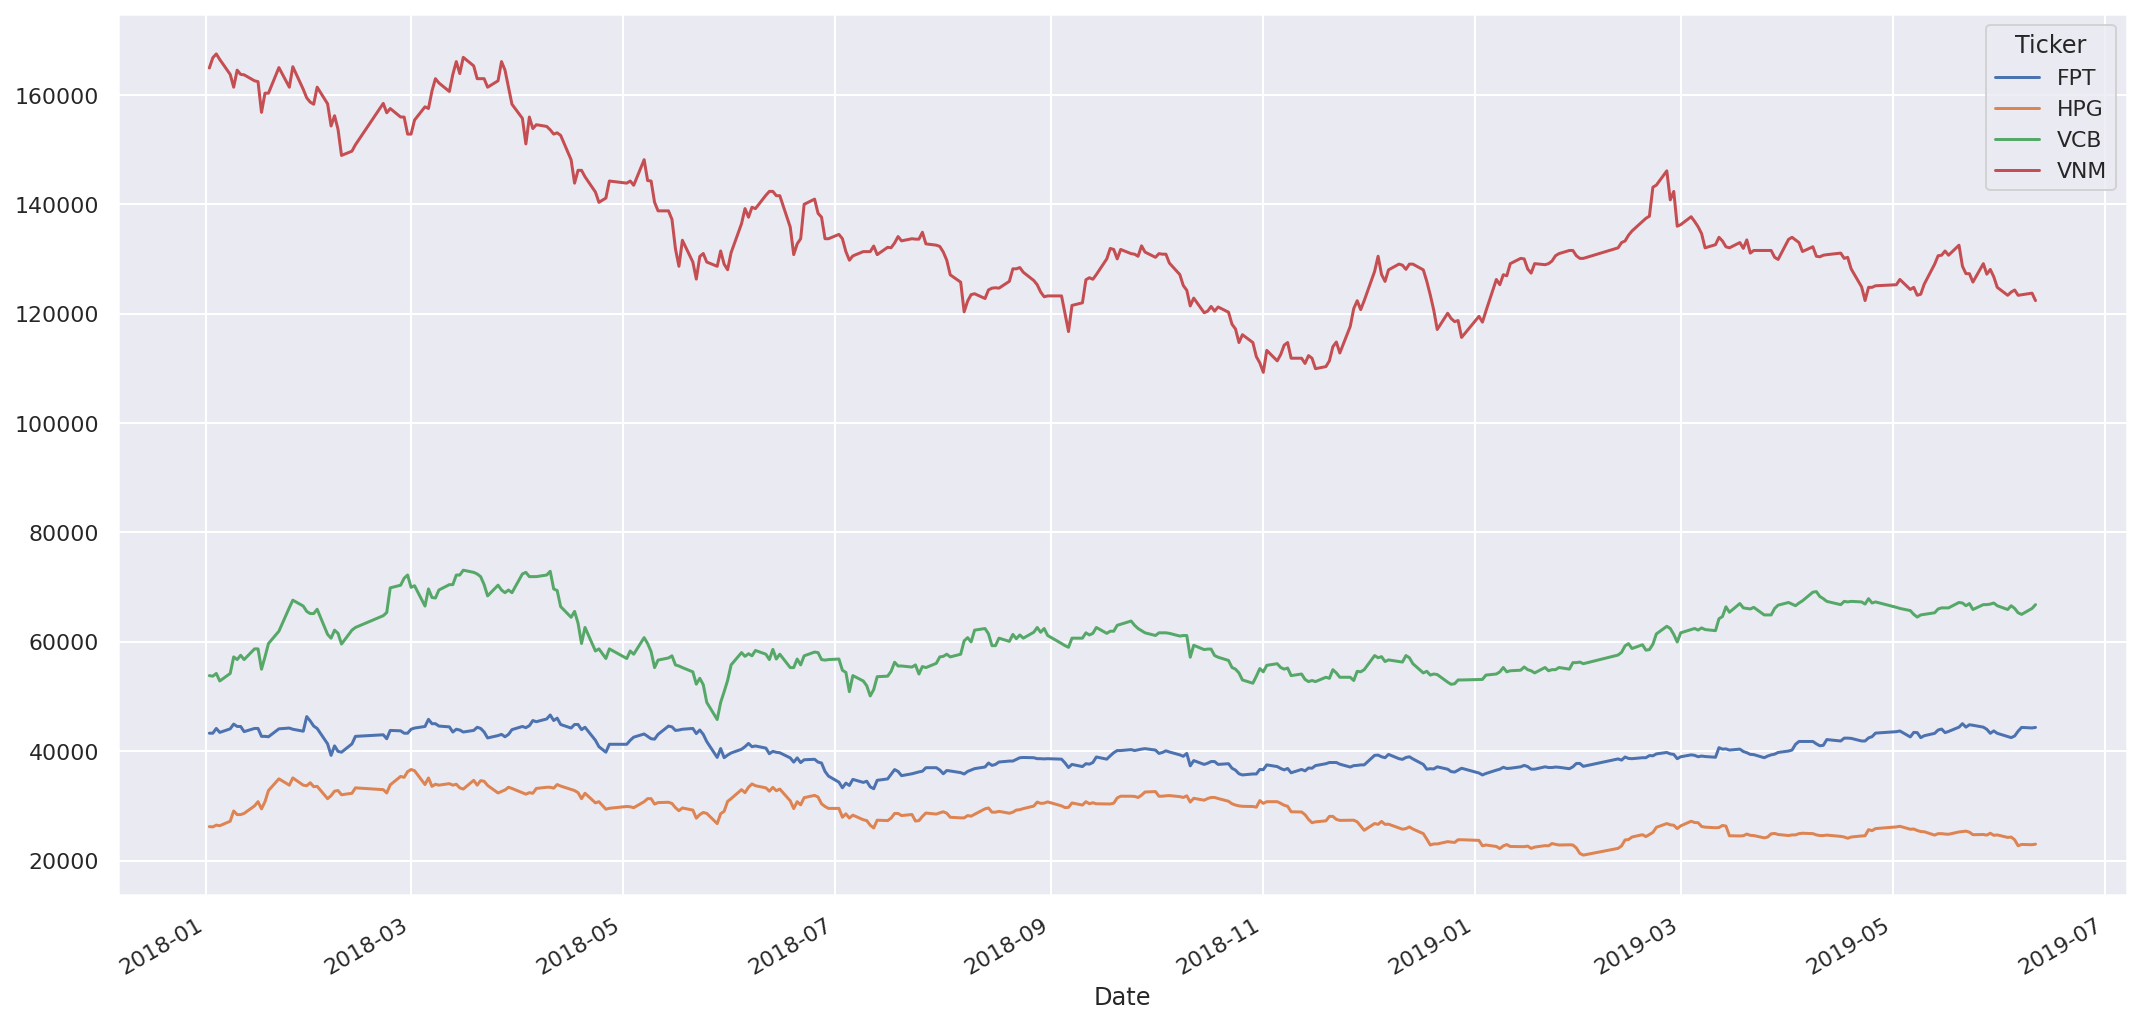

In [3]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(18,9)})

start_date = '2018-01-02'
end_date = '2019-09-28'

fav_stocks = ['VCB', 'HPG', 'FPT', 'VNM'] #, 'MWG'
fav_sectors_L2_vi = ['Bán lẻ L2', 'Công nghệ Thông tin L2', 'Thực phẩm và đồ uống L2', 'Bất động sản L2', 'Ngân hàng L2', 'Y tế L2', 'Ô tô và phụ tùng L2', 'Du lịch và Giải trí L2' ]
fav_sectors_L2_en = ['Banks L2', 'Retail L2', 'Technology L2', 'Travel & Leisure L2', 'Health Care L2', 'Real Estate L2', 'Food & Beverage L2', 'Industrial Goods & Services L2', 'Basic Resources L2'  ]
#import csv & table ---------------------------------
data_index = pd.read_csv('/content/drive/My Drive/data_pricevolume06112019.csv')\
      [['Ticker', 'Date', 'High', 'Low', 'Open', 'Close', 'AdjRatio', 'TotalValue', 'Shares', 'Volume']]
vn30 = pd.read_csv('/content/drive/My Drive/data_analyst/VN30.csv')
vn30 = vn30['Ticker'].values
selected_ratios = pd.read_excel('/content/drive/My Drive/data_analyst/selected_ratios.xlsx')
sector_L2 = pd.read_csv('/content/drive/My Drive/data_analyst/sectorl2.csv')
data_index = pd.merge(data_index, sector_L2, on ='Ticker', how ='left' )

#filter & format
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index['Date'] >= start_date) & (data_index['Date'] <= end_date)  ]  #& (data_index.SectorL2.isin(fav_sectors_L2_en))
#add column
data_index['Year'] = data_index['Date'].apply(lambda x: x.year)
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
data_index['Market_Capitalization'] = data_index['Adj_Close'] * data_index['Shares']
data_index['mcap_weight'] = data_index.groupby(['Date'])['Market_Capitalization'].apply(lambda x: x/(x.sum()))
data_index['day'] = data_index['Date'].dt.day
data_index['quarter'] = data_index['Date'].apply(lambda x: str(x.year) + "Q" + str(x.quarter))
data_index['quarter_end_date'] = data_index.groupby([data_index.Date.dt.year, data_index.Date.dt.quarter])['Date'].tail(1)
# quarter end date to rebalance weights
quarter_end_date_df = data_index.quarter_end_date.dropna().reset_index(drop=True)
#quarter_end_date_list1 = data_index['quarter_end_date'].dt.date.unique().tolist()
#print(quarter_end_date_df.values)

#test VN30 return
vn30df = data_index[data_index.Ticker.isin(vn30)]
vn30_pivot =  vn30df.pivot(columns='Ticker', index='Date', values='Adj_Close')
vn30_pivot_return = vn30_pivot.pct_change()
vn30_weights_ew = np.repeat(1/30, 30)
vn30_pivot_return['VN30'] =  vn30_pivot_return.mul(vn30_weights_ew, axis=1).sum(axis=1)
vn30_pivot_return = (1+ vn30_pivot_return).cumprod() - 1
#vn30_pivot_return.plot()
#vn30_pivot_return = vn30_pivot_return.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})

data_index = data_index[data_index.Ticker.isin(fav_stocks)] #sau chon top10
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')
data_index_pivot.plot()

numstocks = len(fav_stocks)
#data_index = data_index.set_index('Date')

# Set the initial capital
#initial_capital= float(10000000.0)
initial_cash= float(5000000.0)
initial_volume = 1000
total_reb_cost = 0.0
leftover_value = 0

initial_capital = (data_index[ (data_index['Date'] == '2018-01-02') & (data_index.Ticker.isin(fav_stocks))].Adj_Close * initial_volume).sum()
print("Vốn đầu tư ban đầu 1000cp * 4 mã: " + str(initial_capital))

for i in quarter_end_date_df:
  df = data_index[data_index['Date'] <= i]
  df = df[ df.Ticker.isin(fav_stocks) ]   #top10_highest_score_stock    vn30  fav_stocks

  #df = data_index[data_index['Date'] <= i]
  #print(data_index[data_index['Date'] <= i])

  df_pivot = df.pivot(columns='Ticker', index='Date', values='Adj_Close')
  #print(df_pivot)
  returns = df_pivot.pct_change()
  exp_return_d = returns.mean()
  cov_matrix_a = returns.cov() *252   #cov year

  portfolio_weights_mcap = df[df.Date == i].mcap_weight.to_numpy() #co the sai thu tu
  portfolio_weights_ew = np.repeat(1/numstocks, numstocks)   # Benchmark 1/n strategy
  portfolio_weights = np.array([0.4, 0.2, 0.1, 0.3])
  #statistics weight cho truoc
  portfolio_return_a = round(np.sum(exp_return_d * portfolio_weights) * 252,5)
  portfolio_std_dev = round(np.sqrt(np.dot(portfolio_weights.T,np.dot(cov_matrix_a, portfolio_weights))) ,5)
  #statistics equal weight 
  portfolio_return_ew = round(np.sum(exp_return_d * portfolio_weights_ew) * 252,5)
  portfolio_std_dev_ew = round(np.sqrt(np.dot(portfolio_weights_ew.T,np.dot(cov_matrix_a, portfolio_weights_ew))) ,5)
  
  returns['Portfolio'] = returns.mul(portfolio_weights, axis=1).sum(axis=1)
  returns['Portfolio_EW'] =  returns.iloc[:, 0:numstocks].mul(portfolio_weights_ew, axis=1).sum(axis=1)
  returns['Portfolio_MCap'] = returns.iloc[:, 0:numstocks].mul(portfolio_weights_mcap, axis=1).sum(axis=1)
  CummulativeReturns = (1+ returns).cumprod() - 1
  CummulativeReturns = CummulativeReturns.join(vn30_pivot_return.loc[:, "VN30"]).rename(columns={"VN30": "Benchmark"})
  
  #CummulativeReturns[["Portfolio", "Portfolio_EW", 'Portfolio_MCap', 'Benchmark']].plot()  #
  
  print("Expected annualized return: " + str(portfolio_return_a))
  print("Standard deviation (Volatility): " + str(portfolio_std_dev))
  print("portfolio sharpe " + str(np.round(portfolio_return_a/portfolio_std_dev, 4) ))
  print("vs  ")
  print("Expected annualized return ew: " + str(portfolio_return_ew))
  print("Standard deviation (Volatility) ew: " + str(portfolio_std_dev_ew))
  print("portfolio sharpe ew " + str(np.round(portfolio_return_ew/portfolio_std_dev_ew, 4) ))
  
  print(i)
  print("------------")
  # Expected returns and sample covariance
  mu = expected_returns.mean_historical_return(df_pivot)
  S = risk_models.sample_cov(df_pivot)

  # Optimise portfolio for maximum Sharpe Ratio
  ef = EfficientFrontier(mu, S)
  raw_weights = ef.max_sharpe()
  cleaned_weights = ef.clean_weights()
  print(cleaned_weights)
  ef.portfolio_performance(verbose=True, risk_free_rate=0.0)
  print("------------end optimize portfolio")

  #dataframe
  #positions = 
  weight_df = pd.DataFrame(cleaned_weights, columns =['Ticker', 'weight'])
  df_reblancing = df[df.Date == i][['Ticker', 'Adj_Close']]
  
  df_reblancing['current_volume'] = initial_volume #last volume

  print(df_reblancing)
  df_reblancing['current_value'] = df_reblancing['current_volume'] * df_reblancing['Adj_Close']
  #------- đang test
  total_portfolio_value_before_reb = df_reblancing['current_value'].sum()
  latest_prices = df_reblancing.Adj_Close
  
  from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
  # tính volume tối ưu dựa trên weight tối ưu
  print(cleaned_weights)
  weights_rb = cleaned_weights 
  da = DiscreteAllocation(weights_rb, latest_prices, total_portfolio_value=total_portfolio_value_before_reb)
  allocation, leftover = da.lp_portfolio()
  print("Discrete allocation:", allocation)
  print("Funds remaining: VND{:.2f}".format(leftover))
  
  leftover_value = leftover_value + leftover
  weights_allocation_rebal = pd.DataFrame.from_dict(allocation, orient='index').reset_index()
  weights_allocation_rebal.columns=['Ticker', 'reb_volume']

  df_reblancing = df_reblancing.merge(weights_allocation_rebal, on='Ticker', how='left').fillna(0)
  df_reblancing['vol_change'] = df_reblancing['reb_volume'] - df_reblancing['current_volume']
  df_reblancing['buy/sell'] = df_reblancing['vol_change'].apply(lambda x: 'BUY' if x>0 else 'SELL')
  df_reblancing['value_change'] = df_reblancing['vol_change'] * df_reblancing['Adj_Close']
  df_reblancing['reb_cost'] = df_reblancing.apply(lambda row: row['value_change'] * 0.1/100 if row['buy/sell'] == 'BUY' else row['value_change'] * -0.2/100, axis=1 )
  df_reblancing['Adj_value'] = df_reblancing['reb_volume'] * df_reblancing['Adj_Close']
  total_reb_cost = total_reb_cost + df_reblancing['reb_cost'].sum()
  total_portfolio_value = df_reblancing['Adj_value'].sum()

  volume_rb =  df_reblancing['reb_volume']
  print(df_reblancing) #print chuan
  print("======================end of each iter")

print("--------------------grand total cost")
print("amount cost to rebalance " + str(total_reb_cost))
cummulative_capital = initial_cash + total_portfolio_value + leftover_value - total_reb_cost

print("amount invested + cash " + str(initial_cash + initial_capital))
print("total return after cost & taxt " + str(cummulative_capital))

In [0]:
import pandas as pd
cleaned_weights = [('FPT', 0.0), ('HPG', 0.0), ('VCB', 1.0), ('VNM', 0.0)]
weight_df = pd.DataFrame(cleaned_weights, columns =['Ticker', 'weight'])
weight_df

rebalancing_df = pd.DataFrame({'Ticker': df.Ticker, 'current_price': df.Adj_Close})
rebalancing_df
import datetime as dt
today = dt.datetime.today().strftime("%Y-%m-%d")
xx = np.array(today)
xx
date = np.array('2015-07-04', dtype=np.datetime64)
date
dates = pd.to_datetime([ '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
initial_capital= float(1000000.0)
print(initial_capital)

allocation
alo = pd.DataFrame.from_dict(allocation, orient='index').reset_index()
alo.columns=['Ticker', 'Reb_volume']
print(alo)
new_df = data_index.merge(alo, on='Ticker', how='left').fillna(0)
new_df


volume_rb =  df_reblancing['reb_volume']
print(type(volume_rb))

weight_df['weight'] = volume_rb
print(weight_df)

test1 = pd.DataFrame({'col1': [1, 2, 3, 4], 'col2': ['hehe', 'blah', 'test', 'nice']})
print(test1)

for i in range(3):
  test1.col1 = 5
  if i > 1:
    print(i)
    test1.col1 = test1.col1 + 1
  print(test1) 
#print(test1)  

#if 'reb_volume' in df_reblancing.columns:
#  df_reblancing['current_volume'] = volume_rb #df_reblancing['reb_volume']
#else:
#  df_reblancing['current_volume'] = initial_volume

print(len(quarter_end_date_df))

1000000.0
  Ticker  Reb_volume
0    VCB      3840.0


KeyError: ignored

In [0]:
import datetime as dt
start_date = '2015-01-01'
#start_date = pd.to_datetime('01-01-2016')
print(start_date)

#for i in pd.date_range(start_date, periods=30)
#  print(i)
#print(data_index['Date'])
print(dt.datetime.now().date())
#index = pd.date_range('10/1/1999', periods=1100)
#print(index)  
quarter_end = pd.date_range(start_date, dt.datetime.now().date(), freq='Q') #2days were skipped on weeken

print("-------------------------")
print(allocation)

data_index.to_csv('test1.csv')

2015-01-01
2020-06-15
-------------------------
{'VCB': 3840.0}


In [0]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

In [0]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

In [0]:
#test từng function
pd.set_option('display.max_columns', None)
#symbol = 'WIKI/AAPL'
symbol = ['VCB']
start='2017-01-01'
end='2017-12-31'

def fetch_historical_prices(symbol, start_date, end_date):
    #df = data_index[(data_index['Ticker'].isin(symbol)) & (data_index['Date'] > start_date) & (data_index['Date'] < end_date) ]
    df = data_index[(data_index['Ticker'].isin(symbol))] 
    #df = data_index[(data_index['Ticker'] == self.symbol] 
    df = df.loc[start_date: end_date]
    return df
print(fetch_historical_prices(symbol, start, end))

#ben duoi chuan het, test thử 

Empty DataFrame
Columns: [Ticker, Date, High, Low, Open, Close, AdjRatio, TotalValue, Shares, Volume, SectorL2, Year, Adj_Close, Market_Capitalization, mcap_weight, day, quarter, quarter_end_date]
Index: []


In [0]:
#symbol = ['VCB']
#start='2017-01-01'
#end='2017-12-31'

class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        #df = data_index[(data_index['Ticker'].isin(self.symbol))] 
        df = data_index[ data_index['Ticker'] == self.symbol ]
        df = df.loc[self.start: self.end]
        return df


    def run(self):
        if self.df is None:
            self.df = self.fetch_historical_prices()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)
#audi = MarketDataSource(symbol, start='2016-01-01', end='2017-12-31')
#audi.fetch_historical_prices()

In [0]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

In [0]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0 #recently realized profits and losses
		self.position_value = 0  #securities is credit into this acct

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

In [0]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

In [0]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

In [0]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

In [0]:
engine = BacktestEngine(
    'VCB', 1000,
    start='2015-01-01',
    end='2017-12-31'
)

In [0]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 1


AttributeError: ignored

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

engine.df_rpnl.plot(figsize=(12, 8));

In [0]:

def fetch_historical_prices(symbol, start, end):
    import quandl

    # Update your Quandl API key here...
    QUANDL_API_KEY = 'vfB6Ln8TQsxweRFnn89J'
    quandl.ApiConfig.api_key = QUANDL_API_KEY
    df = quandl.get(symbol, start_date=start, end_date=end)
    return df
fetch_historical_prices('WIKI/AAPL', start='2015-01-01',
    end='2017-12-31')    